In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

from lstm_chem.utils.config import process_config
from lstm_chem.model import LSTMChem
from lstm_chem.finetuner import LSTMChemFinetuner
from lstm_chem.data_loader import DataLoader

C:\Users\ashis\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ashis\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ashis\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ashis\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [3]:
config = process_config('experiments/2020-03-24/LSTM_Chem/config.json')

modeler = LSTMChem(config, session='finetune')
finetune_dl = DataLoader(config, data_type='finetune')

finetuner = LSTMChemFinetuner(modeler, finetune_dl)
finetuner.finetune()

Loading model architecture from experiments/2020-03-24/LSTM_Chem/model_arch.json ...
Loading model checkpoint from experiments/2020-03-24/LSTM_Chem/checkpoints/LSTM_Chem-22-0.45.hdf5 ...
Loaded the Model.

100%|█████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 16469.03it/s]


loading SMILES...
done.
tokenizing SMILES...
done.


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/12
115/115 [==============================] - 14s 125ms/step - loss: 1.6976
Epoch 2/12
115/115 [==============================] - 14s 122ms/step - loss: 1.3046
Epoch 3/12
115/115 [==============================] - 14s 126ms/step - loss: 1.2776
Epoch 4/12
115/115 [==============================] - 17s 144ms/step - loss: 1.1739
Epoch 5/12
115/115 [==============================] - 16s 136ms/step - loss: 1.0856
Epoch 6/12
115/115 [==============================] - 14s 125ms/step - loss: 1.1411
Epoch 7/12
115/115 [==============================] - 14s 125ms/step - loss: 1.0753
Epoch 8/12
115/115 [==============================] - 15s 133ms/step - loss: 0.9289
Epoch 9/12
115/115 [==============================] - 14s 120ms/step - loss: 0.9283
Epoch 10/12
115/115 [==============================] - 13s 113ms/step - loss: 0.9242
Epoch 11/12
115/115 [============

In [34]:
finetuned_smiles = finetuner.sample(num=100)

In [35]:
with open('./datasets/known_inhibitors_for_corona_virus.smi') as f:
    ksmiles = [l.rstrip() for l in f]
kmols = [Chem.MolFromSmiles(smi) for smi in ksmiles]

Kfps = []
for mol in kmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Kfps.append(fp)

Klen = len(Kfps)

In [36]:
with open('./datasets/known_inhibitors_for_corona_virus_for_fine_tuning.smi') as f:
    fsmiles = [l.rstrip() for l in f]
fmols = [Chem.MolFromSmiles(smi) for smi in fsmiles]

Ffps, Fbvs = [], []
for mol in fmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Fbvs.append(bv)
    
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ffps.append(fp)

Flen = len(Ffps)

In [37]:
Sfps, Sbvs, smols = [], [], []
for smi in finetuned_smiles:
    mol = Chem.MolFromSmiles(smi)
    smols.append(mol)
    
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Sbvs.append(bv)
    
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Sfps.append(fp)

In [38]:
x = Kfps + Ffps + Sfps
pca = PCA(n_components=2, random_state=71)
X = pca.fit_transform(x)

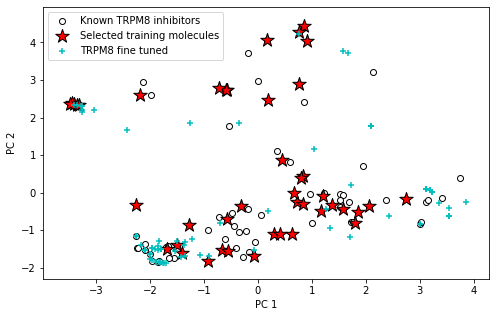

In [39]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:Klen, 0], X[:Klen, 1],
            c='w', edgecolors='k', label='Known TRPM8 inhibitors')
plt.scatter(X[Klen:Klen + Flen, 0], X[Klen:Klen + Flen, 1],
            s=200, c='r', marker='*', edgecolors='k', label='Selected training molecules')
plt.scatter(X[Klen + Flen:, 0], X[Klen + Flen:, 1],
            c='c', marker='+', label='TRPM8 fine tuned')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

In [40]:
idxs = []
for Fbv in Fbvs:
    idx = np.argmax(DataStructs.BulkTanimotoSimilarity(Fbv, Sbvs))
    idxs.append(idx)
nsmols = [smols[idx] for idx in idxs]

In [41]:
showmols = []
for i, j in zip(fmols, nsmols):
    showmols.append(i)
    showmols.append(j)

In [ ]:
Draw.MolsToGridImage(showmols, molsPerRow=2)

In [42]:
for x in finetuned_smiles:
    print(x)

CC(=O)N1CCN(Cc2cccs2)CC1
CC(=O)N1CCN(S(=O)(=O)c2ccc(Cl)cc2)CC1
CS(=O)C1=CC(=O)NCc2cccnc21
CC(=O)N1CCN(C(=O)c2ccccc2)CC1
[Na-]
CS(C)=O
OCCO
CC(=O)N1CCN(CC2=C(C(=O)O)C=C2)CC1
CC(=O)N1CCN(CC2=C[SH]=C2)CC1
CC(=O)[O-]
CC(=O)N1CCN(C2=CC=CC2=O)CC1
CS(=O)COCCNC(=O)O
CC(=O)N1CCC=CC1=O
CC(=O)N1CCN(Cc2cccs2)CC1
CS(C)=O
CC(=O)N1CCN(C(=O)c2cccs2)CC1
CC(=O)N1CCOCC1
CC(=O)N1CCN(C(C)=O)CC1
CC(=O)NC1CCCNC1
CC(=O)N1CCN(C(C)=O)CC1
OCCO
CC(=O)N1CCN(Cc2cccs2)CC1
CC(=O)NCc1ccc(Cl)cc1
CC(=O)[O-]
CC(=O)[O-]
CC(=O)N1CCN(Cc2ccccc2F)CC1
CC(=O)N1CCC(S(=O)(=O)C2=CC=CCC2)CC1
CC(=O)N1CCN(Cc2cccs2)CC1
CC(=O)N1CCN(S(C)(=O)=O)CC1
CC(=O)[O-]
OCCO
O=C(Nc1ccccc1)Nc1ccc(Cl)cc1
OCCO
O=C1NC(CO)CN=C2C=CC=C12
NCC(O)CO
CC(=O)N1CCN(S(=O)(=O)c2ccccc2)CC1
[Na-]
CC(=O)N1CCN(C(C)=O)CC1
CC(=O)N1CCN(C(=O)O)CC1
O=S(=O)([O-])Nc1ccccc1O
O=S(=O)(CCN1CCOCC1)c1cccs1
[Na-]
CC(=O)N1CCN(Cc2ccsc2)CC1
OCCO
NS(=O)(=O)[O-]
CC(=O)N1CCN(CC2=CC=C2C)CC1
CC(=O)N1CCN(CC2=C(C#N)C=C2)CC1
[Na-]
CCNCCCC(=O)N1CCN(C(C)=O)CC1
[Na-]
OCCOCCO
OCCO
CC(=O)N1CCN(Cc2